# Cosmology Likelihood with CCL and Emcee

For now work in fourier-space, do some timing tests, and estimate how much time it will take in real-space to converge and then adjust analysis to handle the time.

In [1]:
import os, math
from astropy.io import fits
import emcee
import pandas as pd
%pylab inline
import seaborn as sns; sns.set_style('darkgrid')
import pyccl as ccl

Populating the interactive namespace from numpy and matplotlib


## Varying Cosmology Parameters

Look at the CCL predictions for our observables for different cosmology parameters and see they change as expected.

In [2]:
# From CCL tutorial, sample fake redshift distribution
z = np.linspace(0., 3., 200)
i_lim = 26. # Limiting i-band magnitude
z0 = 0.0417*i_lim - 0.744

ell = np.arange(2, 2000)
delta_ell = ell[1]-ell[0]
Ngal = 46. * 100.31 * (i_lim - 25.) # Normalisation, galaxies/arcmin^2
pz = 1./(2.*z0) * (z / z0)**2. * np.exp(-z/z0) # Redshift distribution, p(z)
dNdz = Ngal * pz # Number density distribution

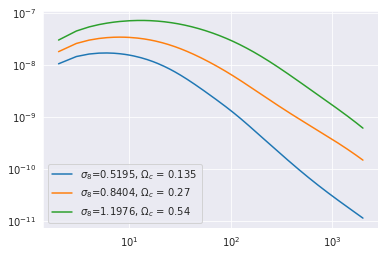

In [3]:
for Omega_c in [0.5,1,2]:
    cosmo = ccl.Cosmology(Omega_c=Omega_c*0.27, Omega_b=0.045, h=0.67, A_s=2.1e-9, n_s=0.96, transfer_function='boltzmann')

    tracer1 = ccl.WeakLensingTracer(cosmo,dndz=(z,dNdz))
    tracer2 = ccl.WeakLensingTracer(cosmo,dndz=(z,dNdz))
    cls = ccl.angular_cl(cosmo, tracer1, tracer2, ell)
    plt.plot(ell, cls, label=r'$\sigma_8$={:.4f}, $\Omega_c$ = {}'.format(ccl.sigma8(cosmo),Omega_c*0.27) )
    plt.legend()
    plt.xscale('log')
    plt.yscale('log')

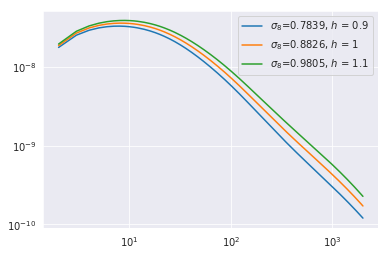

In [4]:
for h in [0.9,1,1.1]:
    cosmo = ccl.Cosmology(Omega_c=0.27, Omega_b=0.045, h=h*0.7, A_s=2.1e-9, n_s=0.96, transfer_function='boltzmann')

    tracer1 = ccl.WeakLensingTracer(cosmo,dndz=(z,dNdz))
    tracer2 = ccl.WeakLensingTracer(cosmo,dndz=(z,dNdz))
    cls = ccl.angular_cl(cosmo, tracer1, tracer2, ell)
    plt.plot(ell, cls, label=r'$\sigma_8$={:.4f}, $h$ = {}'.format(ccl.sigma8(cosmo),h) )
    plt.legend()
    plt.xscale('log')
    plt.yscale('log')

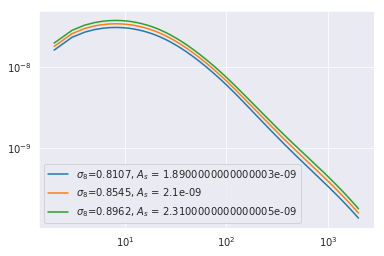

In [5]:
for A_s in [0.9,1,1.1]:
    cosmo = ccl.Cosmology(Omega_c=0.27, Omega_b=0.045, h=0.68, A_s=2.1e-9*A_s, n_s=0.96,transfer_function='boltzmann')

    tracer1 = ccl.WeakLensingTracer(cosmo,dndz=(z,dNdz))
    tracer2 = ccl.WeakLensingTracer(cosmo,dndz=(z,dNdz))
    cls = ccl.angular_cl(cosmo, tracer1, tracer2, ell)
    plt.plot(ell, cls, label=r'$\sigma_8$={:.4f}, $A_s$ = {}'.format(ccl.sigma8(cosmo),2.1e-9*A_s) )
    plt.legend()
    plt.xscale('log')
    plt.yscale('log')

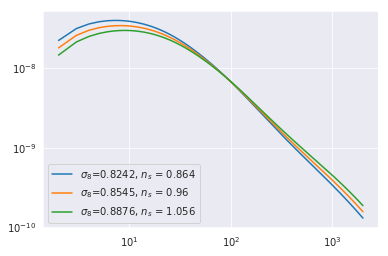

In [6]:
for n_s in [0.9,1,1.1]:
    cosmo = ccl.Cosmology(Omega_c=0.27, Omega_b=0.045, h=0.68, A_s=2.1e-9, n_s=0.96*n_s,transfer_function='boltzmann')

    tracer1 = ccl.WeakLensingTracer(cosmo,dndz=(z,dNdz))
    tracer2 = ccl.WeakLensingTracer(cosmo,dndz=(z,dNdz))
    cls = ccl.angular_cl(cosmo, tracer1, tracer2, ell)
    plt.plot(ell, cls, label=r'$\sigma_8$={:.4f}, $n_s$ = {}'.format(ccl.sigma8(cosmo),0.96*n_s) )
    plt.legend()
    plt.xscale('log')
    plt.yscale('log')

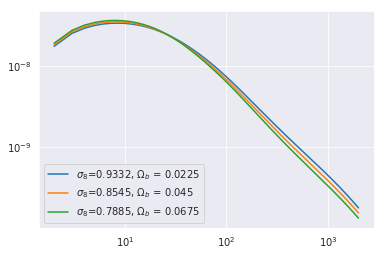

In [7]:
for b in [0.5,1,1.5]:
    cosmo = ccl.Cosmology(Omega_c=0.27, Omega_b=0.045*b, h=0.68, A_s=2.1e-9, n_s=0.96,transfer_function='boltzmann')

    tracer1 = ccl.WeakLensingTracer(cosmo,dndz=(z,dNdz))
    tracer2 = ccl.WeakLensingTracer(cosmo,dndz=(z,dNdz))
    cls = ccl.angular_cl(cosmo, tracer1, tracer2, ell)
    plt.plot(ell, cls, label=r'$\sigma_8$={:.4f}, $\Omega_b$ = {}'.format(ccl.sigma8(cosmo),0.045*b) )
    plt.legend()
    plt.xscale('log')
    plt.yscale('log')

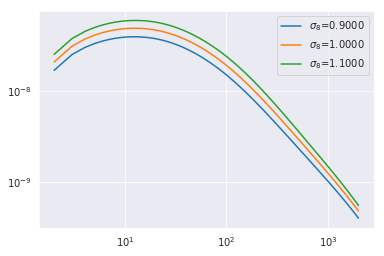

In [8]:
for sigma8 in [0.9,1,1.1]:
    cosmo = ccl.Cosmology(Omega_c=Omega_c*0.27, Omega_b=0.045, h=0.67, n_s=0.96, sigma8=sigma8,transfer_function='boltzmann')

    tracer1 = ccl.WeakLensingTracer(cosmo,dndz=(z,dNdz))
    tracer2 = ccl.WeakLensingTracer(cosmo,dndz=(z,dNdz))
    cls = ccl.angular_cl(cosmo, tracer1, tracer2, ell)
    plt.plot(ell, cls, label=r'$\sigma_8$={:.4f}'.format(sigma8) )
    plt.legend()
    plt.xscale('log')
    plt.yscale('log')

Weak lensing is mostly sensitive to a combination of $\Omega_m$ and $\sigma_8$ where  $\sigma_8 \Omega_m^\alpha \approx Constant$; where $\alpha \approx 0.6$ Since $\Omega_c$ provides the larger contribution to  $\Omega_m$; I'll use  $\sigma_8 \Omega_c^\alpha$.

Using standard values, $\Omega_c = 0.27$, and $\sigma_8 = 0.834$, we can solve  $\sigma_8 \Omega_m^\alpha \approx 0.380$ and use values for both around the standard values to keep this expression constant. We would expect the shear power spectrum to remain approximately constant.

0.380354609373422
0.3801756604945559
0.37999229130215983


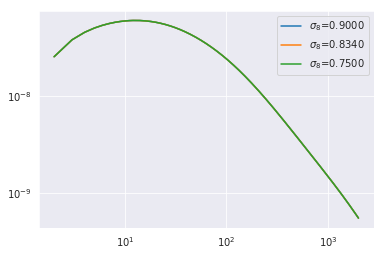

In [9]:
for sigma8,Omega_c in zip([0.9,0.834,0.75],[0.238,0.27,0.322]):
    p = ccl.Cosmology(Omega_c=Omega_c, Omega_b=0.045, h=0.67, n_s=0.96, sigma8=sigma8, transfer_function='boltzmann')

    tracer1 = ccl.WeakLensingTracer(cosmo,dndz=(z,dNdz))
    tracer2 = ccl.WeakLensingTracer(cosmo,dndz=(z,dNdz))
    cls = ccl.angular_cl(cosmo, tracer1, tracer2, ell)
    plt.plot(ell, cls, label=r'$\sigma_8$={:.4f}'.format(sigma8))
    plt.legend()
    plt.xscale('log')
    plt.yscale('log')
    print(sigma8*(Omega_c**0.6))

## Covariance Matrix

In [10]:
z = np.linspace(0., 3., 200)
i_lim = 26. # Limiting i-band magnitude
z0 = 0.0417*i_lim - 0.744

ell = np.arange(2, 2000)
delta_ell = ell[1]-ell[0]
Ngal = 46. * 100.31 * (i_lim - 25.) # Normalisation, galaxies/arcmin^2
pz = 1./(2.*z0) * (z / z0)**2. * np.exp(-z/z0) # Redshift distribution, p(z)
dNdz = Ngal * pz # Number density distribution

In [11]:
Omega_c_true = 0.27
sigma8_true = 0.83

In [12]:
# Generating fake data
cosmo = ccl.Cosmology(Omega_c=0.27, Omega_b=0.045, h=0.67, n_s=0.96,  sigma8=0.83, transfer_function='bbks')

tracer1 = ccl.WeakLensingTracer(cosmo,dndz=(z,dNdz))
tracer2 = ccl.WeakLensingTracer(cosmo,dndz=(z,dNdz))
data    = ccl.angular_cl(cosmo, tracer1, tracer2, ell) #C_ell

In [13]:
# TODO Replace with calculated covariance matrix 
import emcee
# C_ell^2/(Area of LSST survey*ell*delta ell)
cov = np.diag(data**2)*2*np.pi/((4*np.pi*18000)*(np.pi/180)**2*ell*delta_ell) 
icov = np.linalg.inv(cov) #inverse of cov

Text(0,0.5,'$C_\\ell$')

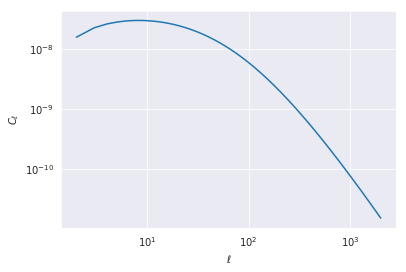

In [14]:
plt.plot(ell,data)
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$\ell$')
plt.ylabel(r'$C_\ell$')

## Run the MCMC 

Let's define our model that we want to test against our data. We'll use the same redshift distribution as above.

We will define ln(probability) (easier computationally that probability). Theta is the set of $\Omega_c$ and $\sigma_8$

For the likelihood analysis, we'll use MCMC to find the set of parameters that minimises $\chi^2 =(d - t)^T \cdot \Sigma^{-1} \cdot (d-t)$, with $\Sigma$: the covariance matrix $d$: data, and $t$: theory. The likelihood is then $L = e^{- \chi^2 / 2}$

In [15]:
# First, define the probability distribution that you would like to sample.

def lnprob(theta):
    for i in range(len(theta)):
        cosmo = ccl.Cosmology(
            Omega_c=theta[0], Omega_b=0.045, h=0.67, n_s=0.96, sigma8=theta[1], 
            transfer_function='bbks')
        
        tracer1 = ccl.WeakLensingTracer(cosmo,dndz=(z,dNdz))
        tracer2 = ccl.WeakLensingTracer(cosmo,dndz=(z,dNdz))
        model = ccl.angular_cl(cosmo, tracer1, tracer2, ell)
        diff = data-model
    #print(np.dot(diff,np.dot(icov,diff))/2.0)
    return -np.dot(diff,np.dot(icov,diff))/2.0

In [16]:
# Sample a 2-dimensional Gaussian
ndim = 2

In [17]:
# Choose an initial set of positions for the walkers as a 2-d gaussian around the true value:
nwalkers = 10
#p0 = [np.array([Omega_c_true,sigma8_true])*np.ones(ndim)+np.array([0.05,0.1]) * numpy.random.rand() for i in range(nwalkers)] 
#p0 = np.array(p0)
#p0 = p0 - len(p0)*[[0.025,0.05]]

def gauss_2d(mux,muy, sigmax,sigmay):
    x = random.normal(mux, sigmax)
    y = random.normal(muy, sigmay)
    return (x, y)

p0 = np.array([gauss_2d(Omega_c_true,sigma8_true,0.1*Omega_c_true,0.1*sigma8_true) for i in range(nwalkers)])

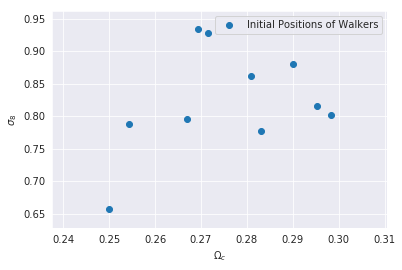

In [18]:
plt.scatter(p0[:,0],p0[:,1],label='Initial Positions of Walkers')
plt.xlabel(r"$\Omega_c$")
plt.ylabel(r"$\sigma_8$")
plt.legend(loc='best')

In [19]:
# Initialize the sampler with the chosen specs.
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob)

In [20]:
# Run 50 steps as a burn-in
%time pos, prob, state = sampler.run_mcmc(p0, 50)

CPU times: user 4min 21s, sys: 50.1 s, total: 5min 11s
Wall time: 4min 11s


In [21]:
burnin_samples = sampler.chain[:, :, :].reshape((-1, ndim))

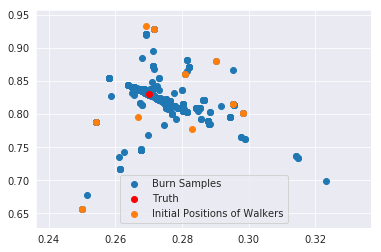

In [22]:
plt.scatter(burnin_samples[:,0],burnin_samples[:,1],label='Burn Samples')
plt.scatter([Omega_c_true],[sigma8_true],c='red',label='Truth')
plt.scatter(p0[:,0],p0[:,1],label='Initial Positions of Walkers')
plt.legend(loc='best')

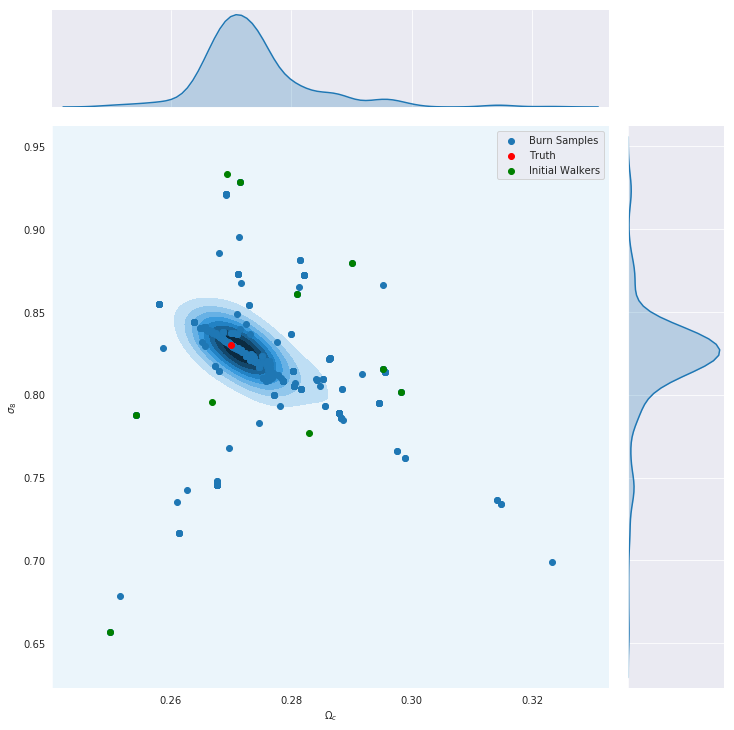

In [23]:
graph = sns.jointplot(
    burnin_samples[:,0],
    burnin_samples[:,1],
    kind='kde',
    stat_func=None,
    height=10,).set_axis_labels(r"$\Omega_c$", r"$\sigma_8$")
graph.x = burnin_samples[:,0]
graph.y = burnin_samples[:,1]
graph.plot_joint(plt.scatter,label='Burn Samples')
graph.x = [Omega_c_true]
graph.y = [sigma8_true]
graph.plot_joint(plt.scatter,c='red',label='Truth')
graph.x = p0[:,0]
graph.y = p0[:,1]
graph.plot_joint(plt.scatter,c='green',label='Initial Walkers')
plt.legend(loc='best')

In [24]:
# Reset the chain to remove the burn-in samples
sampler.reset()

In [25]:
# Starting from the final position in the burn-in chain, sample for 100 steps
%time sampler.run_mcmc(pos, 2000, rstate0=state);

CPU times: user 2h 44min 36s, sys: 33min 53s, total: 3h 18min 30s
Wall time: 2h 39min 23s


(array([[0.26937805, 0.83158202],
        [0.27096883, 0.82778045],
        [0.2695652 , 0.8311331 ],
        [0.27057171, 0.82873362],
        [0.2702132 , 0.82951071],
        [0.2697325 , 0.83066562],
        [0.27038482, 0.82893903],
        [0.26968638, 0.83071435],
        [0.26969173, 0.83084613],
        [0.26978877, 0.83066717]]),
 array([-0.72722222, -3.91311908, -0.47402069, -2.13334452, -0.19109165,
        -0.12506213, -0.92972914, -0.46812986, -0.54082297, -1.32706168]),
 ('MT19937', array([  96141837,  788509465, 2267762043, 1378190575,  778230046,
         1278711555,  357453940, 3987272474,  585949512, 4193394751,
          543907303, 2755704422, 1073364863, 2430230760, 1530580913,
         3092138716, 1869576028,  146590172,  471199580, 1853948846,
          668457158, 2488308858, 1452764875,  413321219, 3812208957,
         4014560640, 3620420077, 2927220692, 1693915273,  249382221,
         1125758553, 3676987421, 2753351232, 4004089018, 1449069258,
          949544

In [26]:
# Estimate the integrated autocorrelation time for the time series in each
# parameter.
#https://emcee.readthedocs.io/en/latest/user/autocorr/
#A good heuristic for assessing convergence of samplings is the integrated autocorrelation time. 
#print "Autocorrelation time:", sampler.get_autocorr_time()

In [27]:
# Print out the mean acceptance fraction. In general, acceptance_fraction has an entry for each walker so, in this case, it is a 10-dimensional vector.

In [28]:
print("Mean acceptance fraction:", np.mean(sampler.acceptance_fraction))

Mean acceptance fraction: 0.7145999999999999


In [29]:
help(sampler.get_autocorr_time)

Help on method get_autocorr_time in module emcee.ensemble:

get_autocorr_time(low=10, high=None, step=1, c=10, fast=False) method of emcee.ensemble.EnsembleSampler instance
    Compute an estimate of the autocorrelation time for each parameter
    (length: ``dim``).
    
    :param low: (Optional[int])
        The minimum window size to test.
        (default: ``10``)
    :param high: (Optional[int])
        The maximum window size to test.
        (default: ``x.shape[axis] / (2*c)``)
    :param step: (Optional[int])
        The step size for the window search.
        (default: ``1``)
    :param c: (Optional[float])
        The minimum number of autocorrelation times needed to trust the
        estimate.
        (default: ``10``)
    :param fast: (Optional[bool])
        If ``True``, only use the first ``2^n`` (for the largest power)
        entries for efficiency.
        (default: False)



In [30]:
print("Auto-correlation time",sampler.get_autocorr_time(c=3))

Auto-correlation time [43.73895589 43.97680852]


In [31]:
#Mean acceptance fraction: 0.725
#Get the samples from the results to plot them later:

In [32]:
samples = sampler.chain[:, :, :].reshape((-1, ndim))

In [33]:
#Results as mean and $95\%$ Confidence interval of $\Omega_c$ and $\sigma_8$:

In [34]:
map(lambda v: (v[1], v[2]-v[1], v[1]-v[0]),
                             zip(*np.percentile(samples, [2.5, 50, 97.5],
                                                axis=0)))

In [35]:
#Results as a contour plot of the two parameters $-$ $\Omega_c$ and $\sigma_8$:

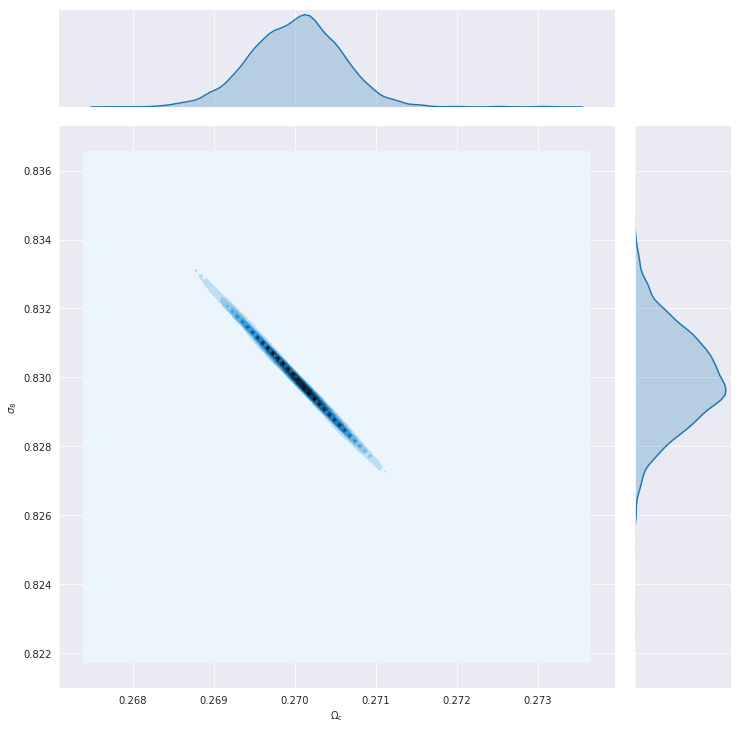

In [36]:
g = sns.jointplot(
    samples[:,0],
    samples[:,1],
    kind='kde',
    stat_func=None,
    height=10,).set_axis_labels(r"$\Omega_c$", r"$\sigma_8$")
#g.plot_joint(plt.scatter, c="w", s=30, linewidth=1, marker="+")
#g.ax_joint.collections[0].set_alpha(0)
#g.set_axis_labels("$X$", "$Y$");

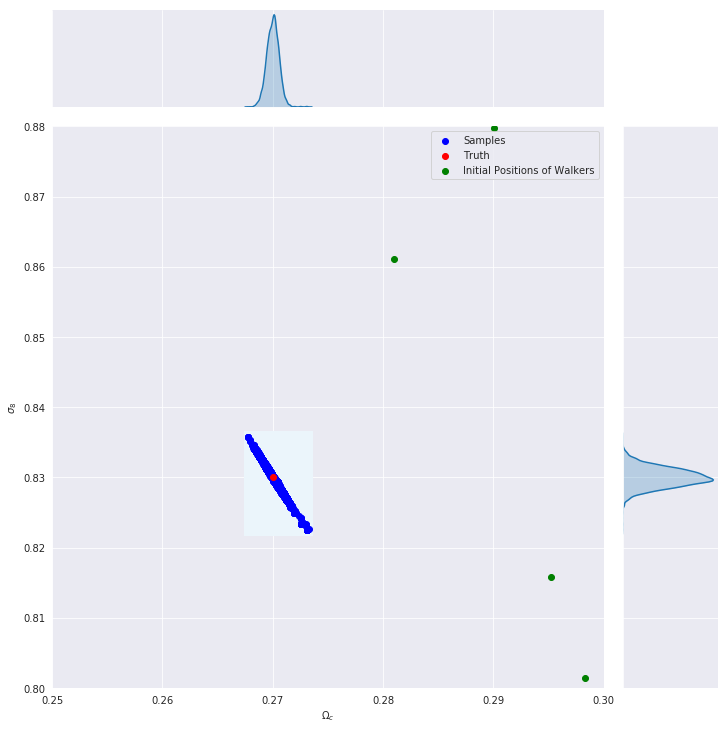

In [37]:
graph = sns.jointplot(
    samples[:,0],
    samples[:,1],
    kind='kde',
    stat_func=None,
    height=10,ylim=(0.80,0.88),xlim=(0.25,0.3)).set_axis_labels(r"$\Omega_c$", r"$\sigma_8$")
graph.x = samples[:,0]
graph.y = samples[:,1]
graph.plot_joint(plt.scatter,c='blue',label='Samples')
graph.x = [0.27]
graph.y = [0.83]
graph.plot_joint(plt.scatter,c='red',label='Truth')
graph.x = p0[:,0]
graph.y = p0[:,1]
graph.plot_joint(plt.scatter,c='green',label='Initial Positions of Walkers')
plt.legend(loc='best')

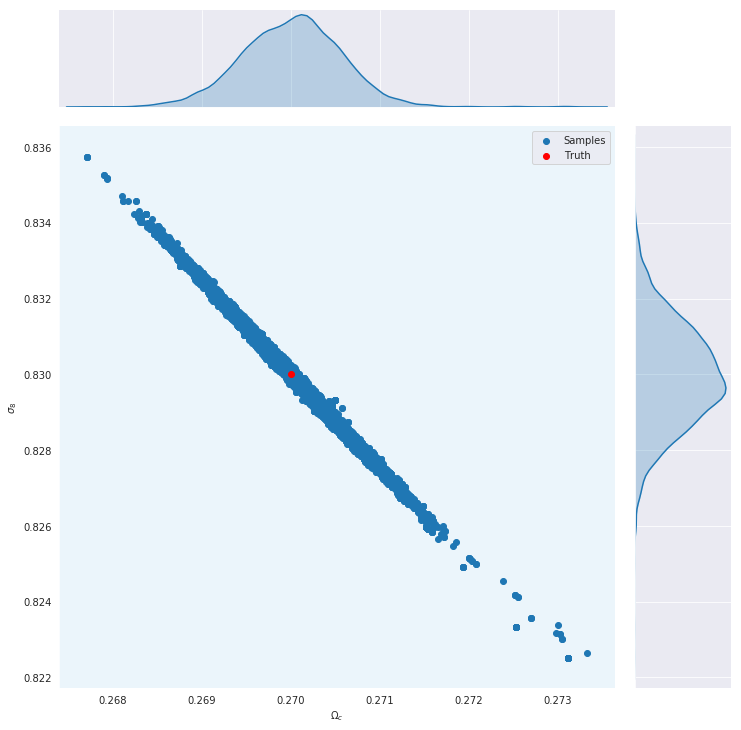

In [38]:
graph = sns.jointplot(
    samples[:,0],
    samples[:,1],
    kind='kde',
    stat_func=None,
    height=10,).set_axis_labels(r"$\Omega_c$", r"$\sigma_8$")
graph.x = samples[:,0]
graph.y = samples[:,1]
graph.plot_joint(plt.scatter,label='Samples')
graph.x = [0.27]
graph.y = [0.83]
graph.plot_joint(plt.scatter,c='red',label='Truth')
plt.legend(loc='best')